This notebook obtains emotion classification using DepecheMood (https://arxiv.org/abs/1405.1605) WordNet with the help of textacy API (https://textacy.readthedocs.io/en/stable/).

Run this notebook from the scripts directory.

In [1]:
import pandas as pd
import textacy.resources

In [2]:
amazon = pd.read_csv('../../data/preprocessed/amazon.csv')

In [3]:
# Download the data and save contents to disk (needs to be done only once)
# lemmapos describes text preprocessing (tokenization, lemmatization, and part-of-speech tagging)
rs = textacy.resources.DepecheMood(lang="en", word_rep="lemmapos")
rs.download()
rs.info

{'name': 'depeche_mood',
 'site_url': 'http://www.depechemood.eu',
 'publication_url': 'https://arxiv.org/abs/1810.03660',
 'description': 'A simple tool to analyze the emotions evoked by a text.'}

In [4]:
# Define DepecheMood emotions
wordnet_emotions = ['AFRAID', 'AMUSED', 'ANGRY', 'ANNOYED', 'DONT_CARE', 'HAPPY', 'INSPIRED', 'SAD']

In [5]:
# Prepare amazon csv for recording results.
amazon['PREDICTION'] = 0
for emotion in wordnet_emotions:
    amazon[emotion] = 0
amazon

,REVIEW_TEXT,VERACITY,PREDICTION,AFRAID,AMUSED,ANGRY,ANNOYED,DONT_CARE,HAPPY,INSPIRED,SAD
0,"When least you think so, this product will sav...",Fake,0,0,0,0,0,0,0,0,0
1,Lithium batteries are something new introduced...,Fake,0,0,0,0,0,0,0,0,0
2,I purchased this swing for my baby. She is 6 m...,Fake,0,0,0,0,0,0,0,0,0
3,I was looking for an inexpensive desk calcolat...,Fake,0,0,0,0,0,0,0,0,0
4,I only use it twice a week and the results are...,Fake,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
20969,"I bought these for work. I have high arches, ...",Real,0,0,0,0,0,0,0,0,0
20970,Crocs are one of only two brands of shoes that...,Real,0,0,0,0,0,0,0,0,0
20971,I love moccasins This fit like it was custom ...,Real,0,0,0,0,0,0,0,0,0
20972,I wish these were a little more durable. I got...,Real,0,0,0,0,0,0,0,0,0


In [6]:
for i in range(len(amazon['REVIEW_TEXT'])):
    if i%1000 == 0:
        print('Processing', i, ' of 20974')
    text = textacy.make_spacy_doc(amazon['REVIEW_TEXT'][i], lang='en_core_web_sm')
    out = rs.get_emotional_valence(text)
    for emotion in wordnet_emotions:
        amazon.iloc[i, amazon.columns.get_loc(emotion)] = out[emotion]
    amazon.iloc[i, amazon.columns.get_loc('PREDICTION')] = max(out, key=out.get)

Processing 0  of 20974
Processing 1000  of 20974
Processing 2000  of 20974
Processing 3000  of 20974
Processing 4000  of 20974
Processing 5000  of 20974
Processing 6000  of 20974
Processing 7000  of 20974
Processing 8000  of 20974
Processing 9000  of 20974
Processing 10000  of 20974
Processing 11000  of 20974
Processing 12000  of 20974
Processing 13000  of 20974
Processing 14000  of 20974
Processing 15000  of 20974
Processing 16000  of 20974
Processing 17000  of 20974
Processing 18000  of 20974
Processing 19000  of 20974
Processing 20000  of 20974


Let us see emotion predictions distribution

<AxesSubplot:title={'center':'Wordnet Emotion Predictions'}>

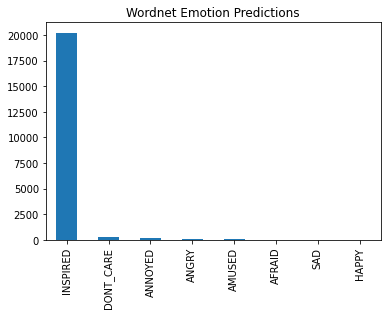

In [9]:
amazon.PREDICTION.value_counts().plot(kind='bar', title='Wordnet Emotion Predictions')

Clearly, INSPIRED overpowers other classes - this class will be removed and values will be normalised to find new matching classes.

In [10]:
amazon_no_inspired = amazon.copy()
amazon_no_inspired.drop(columns=['INSPIRED'], inplace=True)

In [11]:
for i in range(len(amazon_no_inspired)):
    if i%1000 == 0:
        print('Processing', i, ' of 20974')
    vals = []
    # Record probabilities for all emotions but INSPIRED and normalise.
    for emotion in wordnet_emotions:
        if emotion != 'INSPIRED':
            vals.append(amazon_no_inspired[emotion][i])
    norm_vals = [val/sum(vals) for val in vals]
    # Record the new normalised values.
    j = 0
    for emotion in wordnet_emotions:
        if emotion != 'INSPIRED':
            amazon_no_inspired.iloc[i, amazon_no_inspired.columns.get_loc(emotion)] = norm_vals[j]
            j += 1
    # Obtain new predictions.
    out = {}
    for emotion in wordnet_emotions:
        if emotion != 'INSPIRED':
            out[emotion] = amazon_no_inspired[emotion][i]
    amazon_no_inspired.iloc[i, amazon_no_inspired.columns.get_loc('PREDICTION')] = max(out, key=out.get)

Processing 0  of 20974
Processing 1000  of 20974
Processing 2000  of 20974
Processing 3000  of 20974
Processing 4000  of 20974
Processing 5000  of 20974
Processing 6000  of 20974
Processing 7000  of 20974
Processing 8000  of 20974
Processing 9000  of 20974
Processing 10000  of 20974
Processing 11000  of 20974
Processing 12000  of 20974
Processing 13000  of 20974
Processing 14000  of 20974
Processing 15000  of 20974
Processing 16000  of 20974
Processing 17000  of 20974
Processing 18000  of 20974
Processing 19000  of 20974
Processing 20000  of 20974


Check new emotion distribution.

<AxesSubplot:title={'center':'Wordnet Emotion Predictions (without INSPIRED)'}>

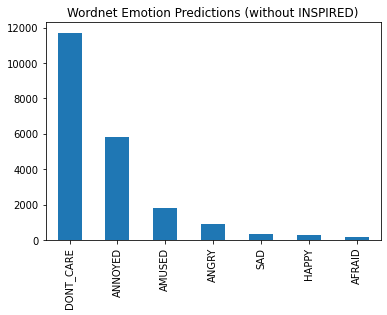

In [14]:
amazon_no_inspired.PREDICTION.value_counts().plot(kind='bar', title='Wordnet Emotion Predictions (without INSPIRED)')

In [15]:
# Save results.
amazon_no_inspired.to_csv('../../data/results/amazon_wordnet.csv', index=False)